In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
import Stemmer
import re
from tqdm import tqdm
import csv
import subprocess
import gc
import networkx as nx
from utils.graph import KGraphPreproc, KnowledgeTriple

In [2]:
fbqa = pd.read_json("/datasets/FreebaseQA/FreebaseQA-eval.json")
def get_fbqa_data(question_row):
    """
    Takes in a dataset row and returns Q and A as strings
    """
    question = question_row.Questions.get("RawQuestion", None)
    parse = question_row.Questions.get("Parses", [None])[0]
    if not parse:
        print(f"error in question: {question}")
        return question, None
    answer = parse.get("Answers")
    return question, answer


In [26]:
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [27]:
def convert_entity(entity, reverse=False):
    """
    converts: m.07j6w into /m/07j6w
    reverse does the opposite
    """
    if reverse:
        return entity[1:].replace("/", ".")
    return "/" + entity.replace(".", "/")

In [28]:
def extract_entities(row):
    q_entities = []
    parses = row.Parses
    for parse in parses:
        parse_json = pd.json_normalize(parse).iloc[0]
        q_entities.append([])
        topic_mid = convert_entity(parse_json.TopicEntityMid)
        entity_set.add(topic_mid)
        q_entities[-1].append(topic_mid)
        for answer in parse_json.Answers:
            answer_mid = convert_entity(answer.get("AnswersMid"))
            entity_set.add(answer_mid)
            q_entities[-1].append(answer_mid)
    return q_entities

In [29]:
entity_set = set()

In [30]:
fbqa_norm = pd.json_normalize(fbqa.Questions)
fbqa_norm["entities"] = fbqa_norm.apply(extract_entities, axis=1)
# fbqa_norm.iloc[:1]

In [31]:
# example of [start, target] paths
fbqa_norm.iloc[2].entities

[['/m/07j6w', '/m/07h5d'],
 ['/m/04z257', '/m/07h5d'],
 ['/m/016z43', '/m/07h5d'],
 ['/m/016z43', '/m/07h5d'],
 ['/m/04z257', '/m/07h5d']]

In [32]:
print("Unique entities in FBQA dataset:", len(entity_set))
print("Entities present in the graph", sum(fbkb_graph._graph.has_node(e) for e in entity_set))

Unique entities in FBQA dataset: 7865
Entities present in the graph 1890


In [9]:
def has_graph_path(row):
    for path in row.entities:
        start = path[0]
        for target in path[1:]:
            try:
                if nx.has_path(fbkb_graph._graph, start, target):
                    return True
            except nx.NodeNotFound:
                continue
    return False

In [43]:
print("Questions with path between nodes:", sum(fbqa_norm.apply(has_graph_path, axis=1)))

Questions with path between nodes: 755


### Complete the KG with extracts from the dump

In [67]:
# get a list of entities not included
not_included_entities = set([convert_entity(e, True) for e in entity_set if not fbkb_graph._graph.has_node(e)])
len(not_included_entities)

5975

In [45]:
import os
print(os.getcwd())
os.chdir("/datasets/FreebaseQA/KB")
print(os.getcwd())

/model
/datasets/FreebaseQA/KB


In [106]:
with open("entities.txt", "w") as f:
    f.write("\n".join(not_included_entities))

### Load the extracted triples (from the dump)

In [11]:
# drop "binary file matches"
triples = pd.read_csv(
    "/datasets/FreebaseQA/KB/filtered_relations.txt", 
    header=None, sep="\t", dtype=str, 
    names=["subject", "relation", "object", "."]
).iloc[:-1]
triples.drop(columns=["."], inplace=True)

In [12]:
# extract
triples.subject = triples.subject.apply(lambda t: t.split("/")[-1][:-1])
triples.relation = triples.relation.apply(lambda t: t.split("/")[-1][:-1])
triples.object = triples.object.apply(lambda t: t.split("/")[-1][:-1])

In [13]:
# convert
triples.subject = triples.subject.apply(convert_entity)
triples.relation = triples.relation.apply(convert_entity)
triples.object = triples.object.apply(convert_entity)

In [18]:
triples.to_csv("/datasets/FB15k-237/kb_dump.csv", header=False, index=False, sep="\t")

In [81]:
# add to the graph
for i, r in triples.iterrows():
    s = r.subject
    o = r.object
    if s and o:
        triplet = KnowledgeTriple(
            s,
            r.relation,
            o
        )
        fbkb_graph.add_triple(triplet)
# 
fbkb_graph.generate_preprocessed_nodes()
fbkb_graph._graph = fbkb_graph._graph.to_undirected()

In [10]:
fbqa_norm["has_path"] = fbqa_norm.apply(has_graph_path, axis=1)

In [11]:
# check the stats again
print("Unique entities in FBQA dataset:", len(entity_set))
print("Entities present in the graph", sum(fbkb_graph._graph.has_node(e) for e in entity_set))

Unique entities in FBQA dataset: 7865
Entities present in the graph 4308


In [84]:
print("Questions with path between nodes:", sum(fbqa_norm.apply(has_graph_path, axis=1)))

Questions with path between nodes: 1369


In [85]:
# Set random seed, sample 1,000 and save
np.random.seed(42)
fbqa_sample = fbqa_norm[fbqa_norm["has_path"]].sample(n=1000)
fbqa_sample.drop(columns=["has_path"]).sort_index().to_csv("/datasets/FreebaseQA/FbQA-eval-1000.csv")

In [194]:
def get_path_length(row):
    path_lens = []
    try:
        for path in row:
            path_lens.append(
                len(nx.shortest_path(fbkb_graph._graph, path[0], path[1]))
            )
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        path_lens.append(-1)
    return path_lens

In [219]:
path_lens = fbqa_norm.entities.apply(get_path_length)
all_path_lens = path_lens.explode().apply(int)

<Axes: >

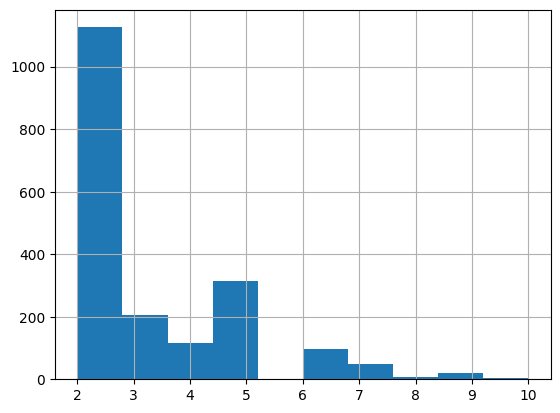

In [222]:
all_path_lens[all_path_lens >= 0].hist()

### Process the dump

In [103]:
import re
pattern = re.compile(r"\b(" + "|".join(map(re.escape, not_included_entities)) + r")\b")
def filter_chunk(chunk):
    mask = chunk.apply(lambda x: x.str.contains(pattern, regex=True, na=False))
    chunk[mask.any(axis=1)]
    # return chunk[
    #     chunk.apply(
    #         lambda row: any(entity in row.to_string(index=False) for entity in not_included_entities), 
    #         axis=1
    #     )
    # ]
    # chunk[chunk[0].isin(not_included_entities) | chunk[2].isin(not_included_entities)]

In [104]:
chunk_size = 100_000
# 1.9B triplet rows
N = 190_000

pbar = tqdm(total=N)

chunks = pd.read_csv(
    "/datasets/FreebaseQA/KB/freebase-rdf-latest.gz", 
    sep="\t", compression="gzip", chunksize=chunk_size,
    dtype=str, header=None
)
results = pd.DataFrame(columns=[0,1,2,3])
for i, chunk in enumerate(chunks):
    chunk_res = filter_chunk(chunk)
    results = pd.concat([results, chunk_res])
    pbar.update(1)
    if i % 100 == 0:
        print(len(results))
# print(i)

0


  0%|          | 3/190000 [00:45<793:49:47, 15.04s/it]


0


0


0


KeyboardInterrupt: 

In [265]:
for entity in not_included_entities:
    command = f'zgrep "{convert_entity(entity, True)}" freebase-rdf-latest.gz > output.txt'
    print(command.split())
    subprocess.run(command.split())
    break

['zgrep', '"m.02q29p"', 'freebase-rdf-latest.gz', '>', 'output.txt']


KeyboardInterrupt: 

### Query WikiData

In [237]:
import requests

# Define the Freebase ID to look up
freebase_id = "/m/07h5dbq"  # Example Freebase ID

# SPARQL query to find the Wikidata entity
sparql_query_1 = f"""
SELECT ?property ?propertyLabel ?value ?valueLabel WHERE {{
  ?item wdt:P646 "{freebase_id}".
  ?item ?p ?value.
  ?property wikibase:directClaim ?p.
  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
}}
"""

sparql_query = f"""
SELECT ?subject ?subjectLabel ?predicate ?predicateLabel ?object ?objectLabel WHERE {{
  # Find the Wikidata entity by Freebase ID
  ?subject wdt:P646 "{freebase_id}".
  
  # Retrieve all outgoing properties and their values
  ?subject ?predicate ?object.
  
  # Get labels for all elements
  SERVICE wikibase:label {{
    bd:serviceParam wikibase:language "en". 
    ?subject rdfs:label ?subjectLabel.
    ?predicate rdfs:label ?predicateLabel.
    ?object rdfs:label ?objectLabel.
  }}
}}
"""

# Endpoint URL
endpoint_url = "https://query.wikidata.org/sparql"

# Request headers
headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

# Make the request
response = requests.get(endpoint_url, params={"query": sparql_query_1, "format": "json"}, headers=headers)

# Parse response
if response.status_code == 200:
    # results = data["results"]["bindings"]
    # for result in results:
    #     print(f"Property: {result['propertyLabel']['value']} ({result['property']['value']})")
    #     print(f"Value: {result.get('valueLabel', {}).get('value', result['value']['value'])}\n")
    data = response.json()
    results = data["results"]["bindings"]
    
    # Print triplets
    for result in results:
        subject = result["subjectLabel"]["value"]
        predicate = result["predicateLabel"]["value"]
        obj = result.get("objectLabel", {}).get("value", result["object"]["value"])
        print(f"({subject}, {predicate}, {obj})")
else:
    print("Error:", response.status_code, response.text)

{'head': {'vars': ['property', 'propertyLabel', 'value', 'valueLabel']}, 'results': {'bindings': []}}
